In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [36]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [38]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [40]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect the table attributes

In [9]:
inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [43]:
# Find the most recent date in the data set.
max_query = session.query(func.max(measurement.date)).one()
max_date = max_query[0]
max_date

'2017-08-23'

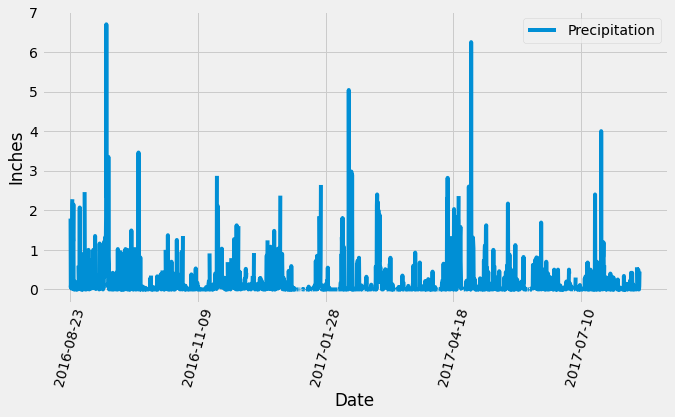

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
max_date_conv = dt.datetime.strptime(max_date, '%Y-%m-%d')

# print('Date:', date_time_obj.date())
start_date = max_date_conv.date()


# Calculate the date one year from the last date in data set.
days_in_year = dt.timedelta(365)
end_date = start_date - days_in_year

# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date.between(end_date, start_date)).statement

# # Save the query results as a Pandas DataFrame and set the index to the date column
rain_in_year = pd.read_sql_query(precipitation_query,session.bind).set_index('date')

# # Sort the dataframe by date
sorted_rain_in_year = rain_in_year.sort_index()

# # Use Pandas Plotting with Matplotlib to plot the data
sorted_rain_in_year.plot(figsize=(10,5))
plt.legend(["Precipitation"], loc= "upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=75)
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_rain_in_year.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.name).count()
print(total_stations)

9


In [48]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).statement

# Show query results
stations_count = pd.read_sql_query(count_stations,session.bind)
stations_count


,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_count.iloc[0].station
station_stats_query = session.query(measurement.station, func.min(measurement.tobs),
                                    func.max(measurement.tobs), func.avg(measurement.tobs),
                                   func.count(measurement.tobs))\
                                    .filter(measurement.station == most_active_station).statement
station_temp = pd.read_sql_query(station_stats_query,session.bind)
station_temp

,station,min_1,max_1,avg_1,count_1
0,USC00519281,54.0,85.0,71.663781,2772


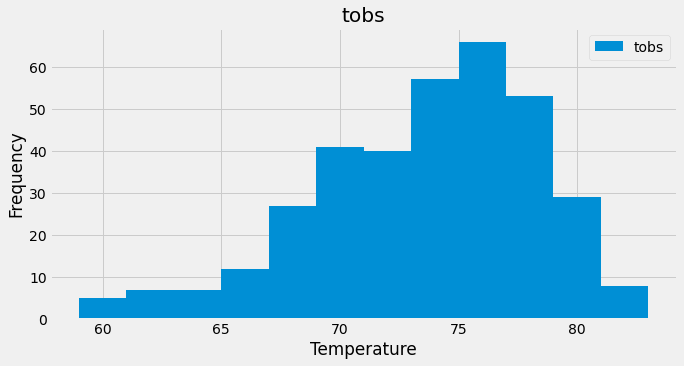

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(measurement.date, measurement.tobs)\
    .filter(measurement.date.between(end_date, start_date))\
    .filter(measurement.station == most_active_station).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
station_temp_year = pd.read_sql_query(temp_query,session.bind).set_index('date')

# Sort the dataframe by date
sorted_station_temp_year = station_temp_year.sort_index()


sorted_station_temp_year.hist( column='tobs', bins=12, figsize=(10,5))
plt.legend(["tobs"], loc= "upper right")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
# plt.xticks(rotation=75)
plt.show()

# Close session

In [45]:
# Close Session
session.close()